In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [4]:
PATH = "data/dogbreed/"
sz = 224
arch= resnext50
bs = 64

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)          # get random 20% of labels for val idx

## Step 1
### Enable data augmentation, precompute=True

In [6]:
# create function to make it easy to vary img sz and bs for sota technique
# of increasing img sz and bs to prevent overfitting
def get_data(sz, bs):
    tfms = tfms_from_model(arch,sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}labels.csv',
                                        test_name='test', num_workers=4,
                                        val_idxs=val_idxs, suffix=".jpg",
                                        tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340,'tmp')   

In [12]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
#learn.fit(1e-2, 5)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

## Step 2
### Learning Rate Finder

In [8]:
lfr = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|███████   | 90/128 [00:00<00:00, 101.44it/s, loss=15.2]


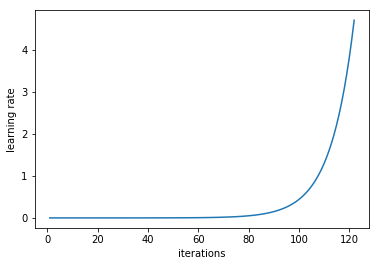

In [9]:
learn.sched.plot_lr()

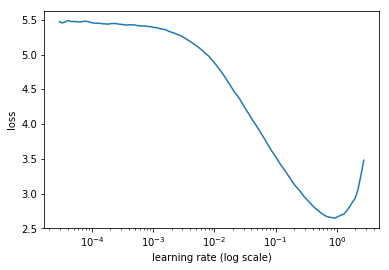

In [10]:
learn.sched.plot()

In [13]:
1e-1, pow(10,-1), 10**-1

(0.1, 0.1, 0.1)

## Step 3
### Train last layer with precomputed activations

In [13]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.356435   0.516203   0.882161  
    1      0.649076   0.372333   0.902669  



[0.3723328, 0.902669271454215]

## Step 4
### Train last layer with data augmentation(ie. precompute=False) for 2-3 epochs, cycle_len=1

In [15]:
learn.precompute=False
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.435729   0.308123   0.903158  
    1      0.411381   0.29721    0.902214  
    2      0.395301   0.294251   0.906152  
    3      0.363094   0.292198   0.906608  
    4      0.34976    0.290315   0.903223  



[0.29031485, 0.903222655877471]

## Step 5 jump to Step 8
### Step 5 - unfreeze all layers
### Step 6 - set differential lr
### step 7 - find lr again ( for what?)
### step 8 - Train full network with cycle_mult=2 until overfitting

### Did not unfreeze becos result is not getting better, because images are too similar to imagenet's, thus doesn't improve to train the filter layers. So we go straight to Step 8

In [16]:
learn.set_data(get_data(299,bs))
learn.freeze()
% time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.347219   0.267942   0.913477  
    1      0.335738   0.260982   0.911035  
    2      0.309181   0.257374   0.912988  
    3      0.301881   0.258165   0.914974  
    4      0.299811   0.257177   0.9125    
    5      0.264777   0.252175   0.9125    
    6      0.254588   0.25064    0.912012  

CPU times: user 40min 23s, sys: 1h 54s, total: 1h 41min 17s
Wall time: 13min 24s


[0.25064045, 0.912011718377471]

### File format for kaggle
'''
id,affenpinscher,afghan_hound,..,yorkshire_terrier

000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.
'''

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy_np(probs, y)
#metrics.log_loss(y, probs)

In [27]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y) #metrics.log_loss(y, probs)

0.006855266969199575

In [28]:
probs.shape

(10357, 120)

In [29]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [30]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,342ff6aaf1169be5b50d5d5bfee7dd50,1.873375e-07,2.851573e-07,2.593911e-07,0.975029,2.025003e-07,6.973732e-07,1.814769e-06,0.000002,3.897409e-07,...,0.000001,1.666846e-07,3.750872e-06,3.383532e-07,7.723045e-07,0.000003,2.072683e-07,7.995872e-08,0.000616,7.206818e-07
1,5fd4c3dad6367ee986e2f9c4a5358483,1.354099e-05,1.586721e-05,5.833979e-05,0.000096,7.191534e-04,8.226297e-05,2.233172e-05,0.000953,3.214495e-03,...,0.000058,9.145900e-04,2.472739e-04,2.040113e-01,4.947311e-05,0.000169,1.099349e-04,4.189739e-05,0.000344,6.553438e-05
2,3a43689ad0c3a2a3989cd670697fb7de,2.439326e-05,5.196368e-07,4.615485e-06,0.000005,3.086877e-05,2.905544e-07,4.531111e-03,0.000004,2.005487e-06,...,0.000012,4.618090e-05,2.736795e-07,9.184016e-07,1.506919e-06,0.000002,4.604228e-05,4.359619e-07,0.000013,1.127948e-04
3,6479fb9f458435d91d0d066004c2fc33,1.871660e-04,1.136072e-05,3.762071e-06,0.000011,4.605698e-06,3.646188e-05,9.051022e-06,0.000019,3.346601e-06,...,0.000005,1.767963e-05,9.520038e-06,8.652905e-07,4.166549e-06,0.000004,9.279604e-05,2.559088e-05,0.000078,2.170592e-04
4,3af107e3ec5e7e7800fba57ce40ab0a9,9.201250e-07,6.778320e-05,6.161466e-07,0.000022,9.896938e-06,3.365512e-06,3.728637e-07,0.000003,1.607328e-06,...,0.000083,5.247106e-06,1.536754e-06,4.700181e-06,6.436803e-05,0.000002,2.035174e-06,5.538335e-05,0.001069,5.998601e-07


In [32]:
df.shape

(10357, 121)

In [31]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[0]

In [ ]:
fn

In [ ]:
Image.open((PATH+fn).resize(150,150))

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)

im = trn_tfms(Image.open(PATH+fn))
preds = learn.predict_array(im[None]) # create a mini-batch of 1 image for learn.predict_array
np.argmax(preds)